In [1]:
import ee

# connect to google account
#ee.Authenticate()
ee.Initialize()

In [2]:
ow1 = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -134.06616210937497,
              53.72921671251267
            ],
            [
              -133.406982421875,
              53.72921671251267
            ],
            [
              -133.406982421875,
              54.05293900056244
            ],
            [
              -134.06616210937497,
              54.05293900056244
            ],
            [
              -134.06616210937497,
              53.72921671251267
            ]
          ]
        ]
      }
    }
  ]
}

ow2 = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -52.130126953124964,
              47.05515408550346
            ],
            [
              -51.470947265625,
              47.05515408550346
            ],
            [
              -51.470947265625,
              47.42808726171425
            ],
            [
              -52.130126953124964,
              47.42808726171425
            ],
            [
              -52.130126953124964,
              47.05515408550346
            ]
          ]
        ]
      }
    }
  ]
}

si1 = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -64.017333984375,
              60.82884973756654
            ],
            [
              -63.21533203124999,
              60.82884973756654
            ],
            [
              -63.21533203124999,
              61.18562468142281
            ],
            [
              -64.017333984375,
              61.18562468142281
            ],
            [
              -64.017333984375,
              60.82884973756654
            ]
          ]
        ]
      }
    }
  ]
}

si2 = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -95.33935546874996,
              82.40968278690752
            ],
            [
              -94.13085937499996,
              82.40968278690752
            ],
            [
              -94.13085937499996,
              82.57617631552547
            ],
            [
              -95.33935546874996,
              82.57617631552547
            ],
            [
              -95.33935546874996,
              82.40968278690752
            ]
          ]
        ]
      }
    }
  ]
}

In [3]:
from datetime import datetime, timedelta

## select desired image
def createImage(geoJSON, date, polarisation, orbitNumber):
    # set area of interest
    coords = geoJSON['features'][0]['geometry']['coordinates']
    aoi = ee.Geometry.Polygon(coords)
    # set date range
    start_date = date
    end_date = str(datetime.strptime(start_date, "%Y-%m-%d") + timedelta(days=1)).split(' ')[0]
    # find image    
    ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD')
                           .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarisation))
                           .filter(ee.Filter.eq('instrumentMode', 'IW'))
                           .filterBounds(aoi)
                           .filter(ee.Filter.eq('relativeOrbitNumber_start', orbitNumber))
                           .filterDate(ee.Date(start_date), ee.Date(end_date)) 
                           .first()
                           .clip(aoi)
                     )
    ## create map
    location = aoi.centroid().coordinates().getInfo()[::-1]
    # select image
    return ee.Image(ffa_db.select(polarisation))

def searchImage(geoJSON, polarisation):
    # set area of interest
    coords = geoJSON['features'][0]['geometry']['coordinates']
    aoi = ee.Geometry.Polygon(coords)
    # pull boundary
    ffa_db = ee.Image(ee.ImageCollection('COPERNICUS/S1_GRD')
                           .filter(ee.Filter.listContains('transmitterReceiverPolarisation', polarisation))
                           .filter(ee.Filter.eq('instrumentMode', 'IW'))
                           .filterBounds(aoi) 
                           .filterDate(ee.Date('2020-12-21'), ee.Date('2021-03-18')) 
                           .first()
                           .clip(aoi)
                     )
    ## create map
    location = aoi.centroid().coordinates().getInfo()[::-1]

    # select image
    return ee.Image(ffa_db.select(polarisation))

In [4]:
import geemap

## create map
# set center point and basemap
Map = geemap.Map(center=(75, -100), zoom=4)
Map.add_basemap('HYBRID')

# add layers
vis_params = {'min': -20, 'max': 0}

## add map layers
# study area
Map.addLayer(searchImage(ow1, 'VV'), vis_params, "ow_v_search")
Map.addLayer(searchImage(ow2, 'HH'), vis_params, "ow_h_search")
Map.addLayer(searchImage(si1, 'VV'), vis_params, "si_v_search")
Map.addLayer(searchImage(si2, 'HH'), vis_params, "si_h_search")

# display map
Map

Map(center=[75, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

dates1 = pd.date_range(start='2020-06-20',end='2021-06-19').to_pydatetime().tolist()
dates = list()
for date in dates1:
    dates.append(str(date).split(' ')[0])
del dates1

def createBoxPlot(classification, geoJSON, dates, polarisation, orbitNumber,):
    
    x = []
    valid_dates = []
    df = pd.DataFrame(columns=['Classification',
                               'Date',
                               'Polarisation',
                               'Mean',
                               'Variance',
                               'Median',
                               'Standard Deviation',
                               'Mode',
                               'Max',
                               'Min'
                              ])
    mean = 0
    variance = 0
    covariance = 0
    median = 0
    st_dev = 0
    mode = 0
    max_ = 0
    min_ = 0
    for date in dates:
        try:
            # create data
            data = createImage(geoJSON, date, polarisation, orbitNumber)
            hist = data.select(polarisation).reduceRegion(
                ee.Reducer.toList(), bestEffort=True
            ).get(polarisation).getInfo()

            # determine summary statistics
            mean = data.select(polarisation).reduceRegion(
                ee.Reducer.mean(), bestEffort=True
            ).get(polarisation).getInfo()
            variance = data.select(polarisation).reduceRegion(
                ee.Reducer.variance(), bestEffort=True
            ).get(polarisation).getInfo()
            median = data.select(polarisation).reduceRegion(
                ee.Reducer.median(), bestEffort=True
            ).get(polarisation).getInfo()
            std_dev = data.select(polarisation).reduceRegion(
                ee.Reducer.stdDev(), bestEffort=True
            ).get(polarisation).getInfo()
            mode = data.select(polarisation).reduceRegion(
                ee.Reducer.mode(), bestEffort=True
            ).get(polarisation).getInfo()
            max_ = data.select(polarisation).reduceRegion(
                ee.Reducer.max(), bestEffort=True
            ).get(polarisation).getInfo()
            min_ = data.select(polarisation).reduceRegion(
                ee.Reducer.min(), bestEffort=True
            ).get(polarisation).getInfo()

            summaryStats = {
                'Classification': [classification],
                'Date': [date],
                'Polarisation': [polarisation],
                'Mean': [mean],
                'Variance': [variance],
                'Median': [median],
                'Standard Deviation': [std_dev],
                'Mode': [mode],
                'Max': [max_],
                'Min': [min_]
            }
            summary = pd.DataFrame(summaryStats)
            df = df.append(summary, ignore_index = True)

            # prep data for box and whisker plots
            #a = np.array(hist)
            x += [hist]
            valid_dates += [date]
        except:
            pass
    filename = 'summary_%s_%s.csv' % (classification, polarisation)
    df.to_csv(filename.replace(' ', '_'))
    fig = plt.figure(figsize =(20, 14))
    ax = fig.add_subplot(111)
    plt.boxplot(x, showfliers=False)
    ax.set_xticklabels(valid_dates, rotation = 90)
    ax.set_title('%s %s' % (classification, polarisation), fontsize = 24)
    plt.xlabel('date', fontsize=12)
    plt.ylabel('Backscatter (dB)', fontsize=12)
    plt.show()

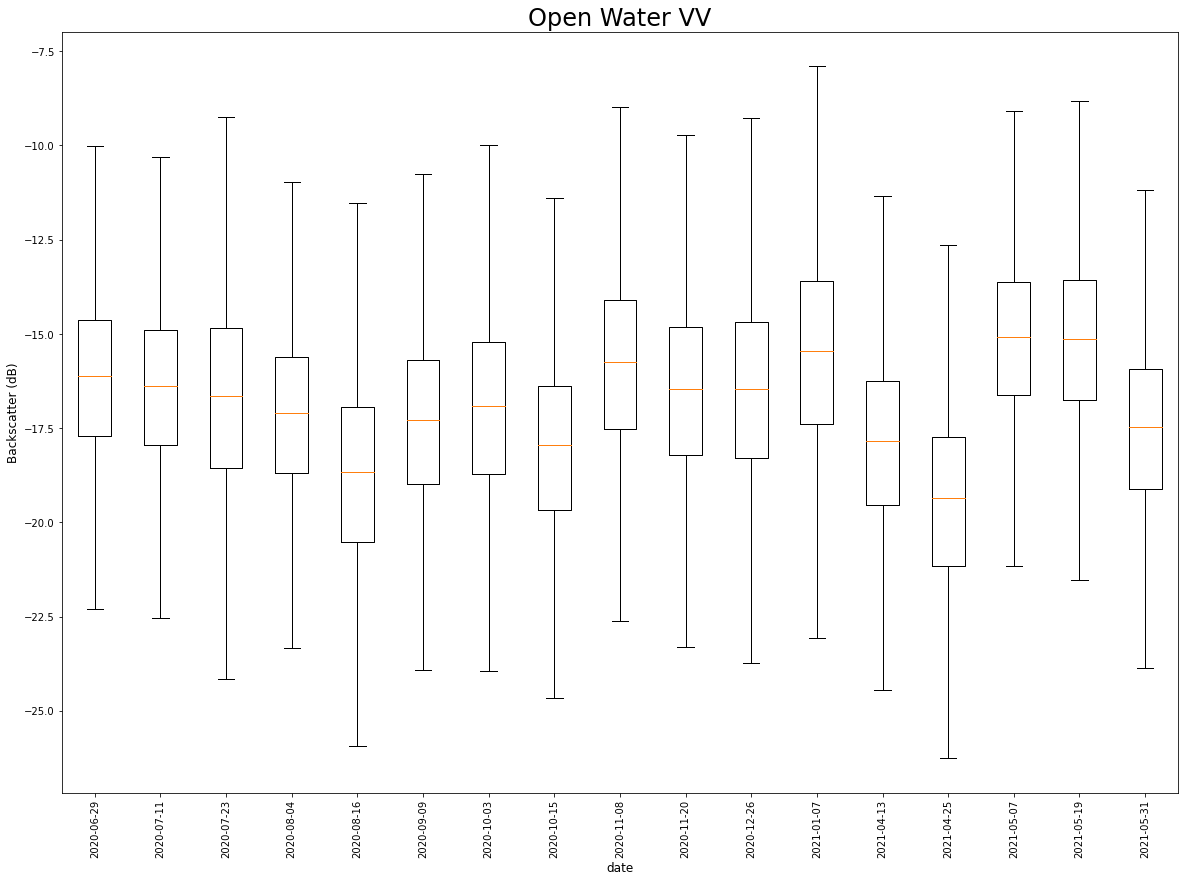

In [6]:
dates_ow_v = [
    '2020-06-29',
    '2020-07-11',
    '2020-07-23',
    '2020-08-04',
    '2020-08-16',
    '2020-09-09',
    '2020-10-03',
    '2020-10-15',
    '2020-11-08',
    '2020-11-20',
    '2020-12-26',
    '2021-01-07',
    '2021-04-13',
    '2021-04-25',
    '2021-05-07',
    '2021-05-19',
    '2021-05-31'
]

createBoxPlot('Open Water', ow1, dates_ow_v, 'VV', 79)

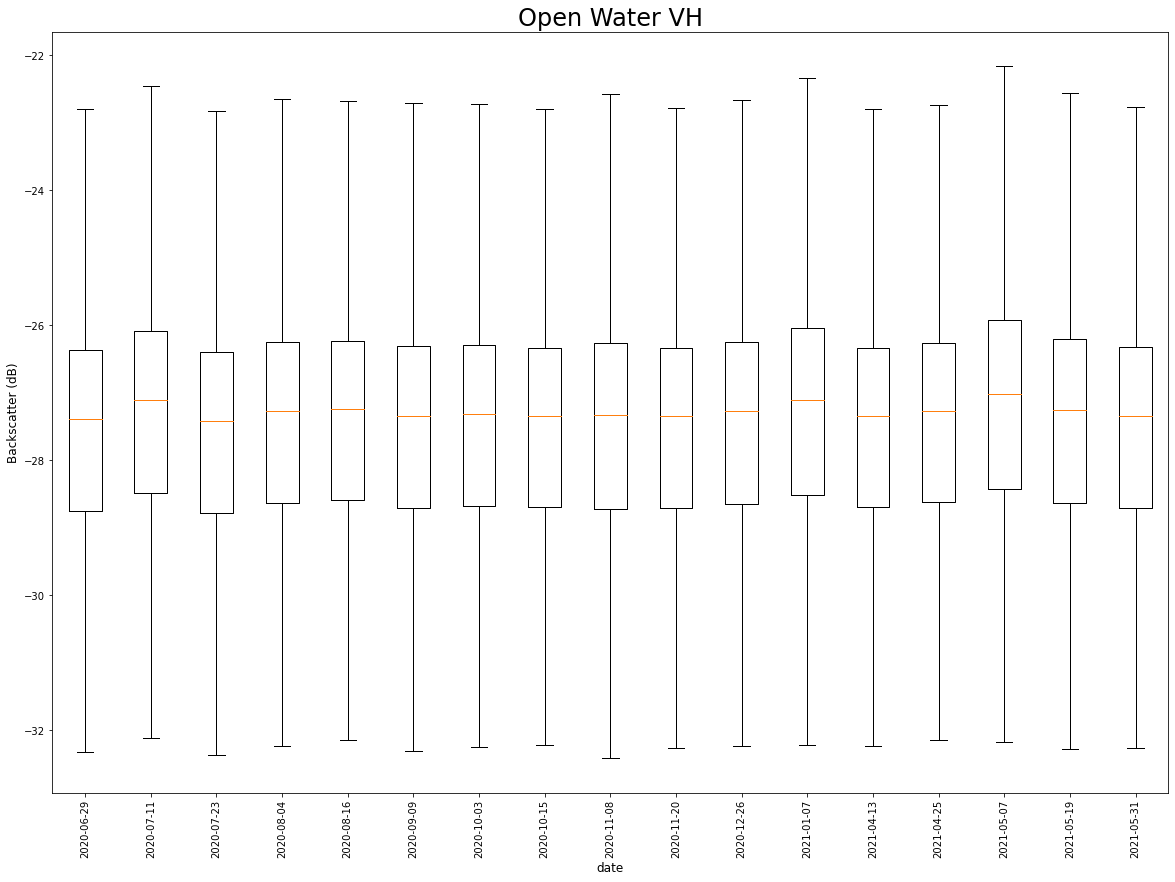

In [7]:
createBoxPlot('Open Water', ow1, dates_ow_v, 'VH', 79)

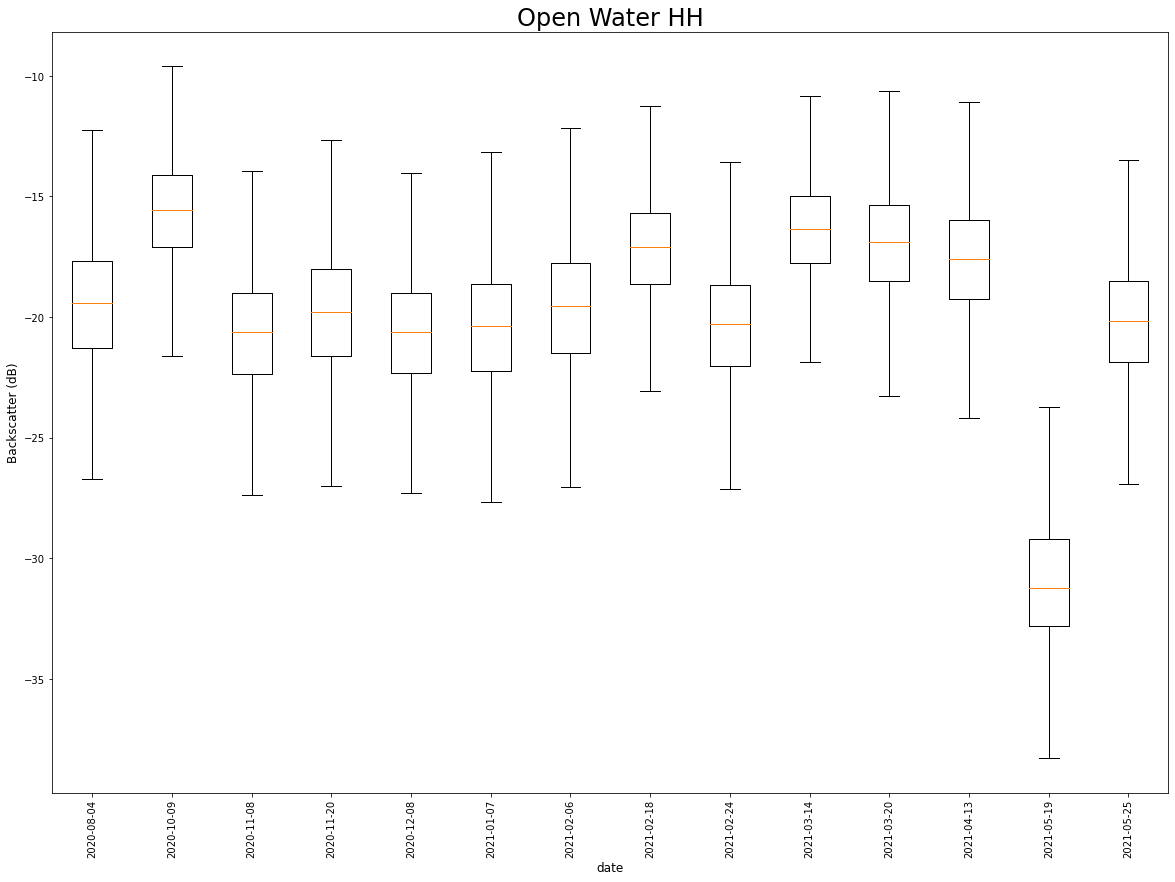

In [8]:
dates_ow_h = [
    '2020-08-04',
    '2020-10-09',
    '2020-11-08',
    '2020-11-20',
    '2020-12-08',
    '2021-01-07',
    '2021-02-06',
    '2021-02-18',
    '2021-02-24',
    '2021-03-14',
    '2021-03-20',
    '2021-04-13',
    '2021-05-19',
    '2021-05-25'
]

createBoxPlot('Open Water', ow2, dates_ow_h, 'HH', 83)

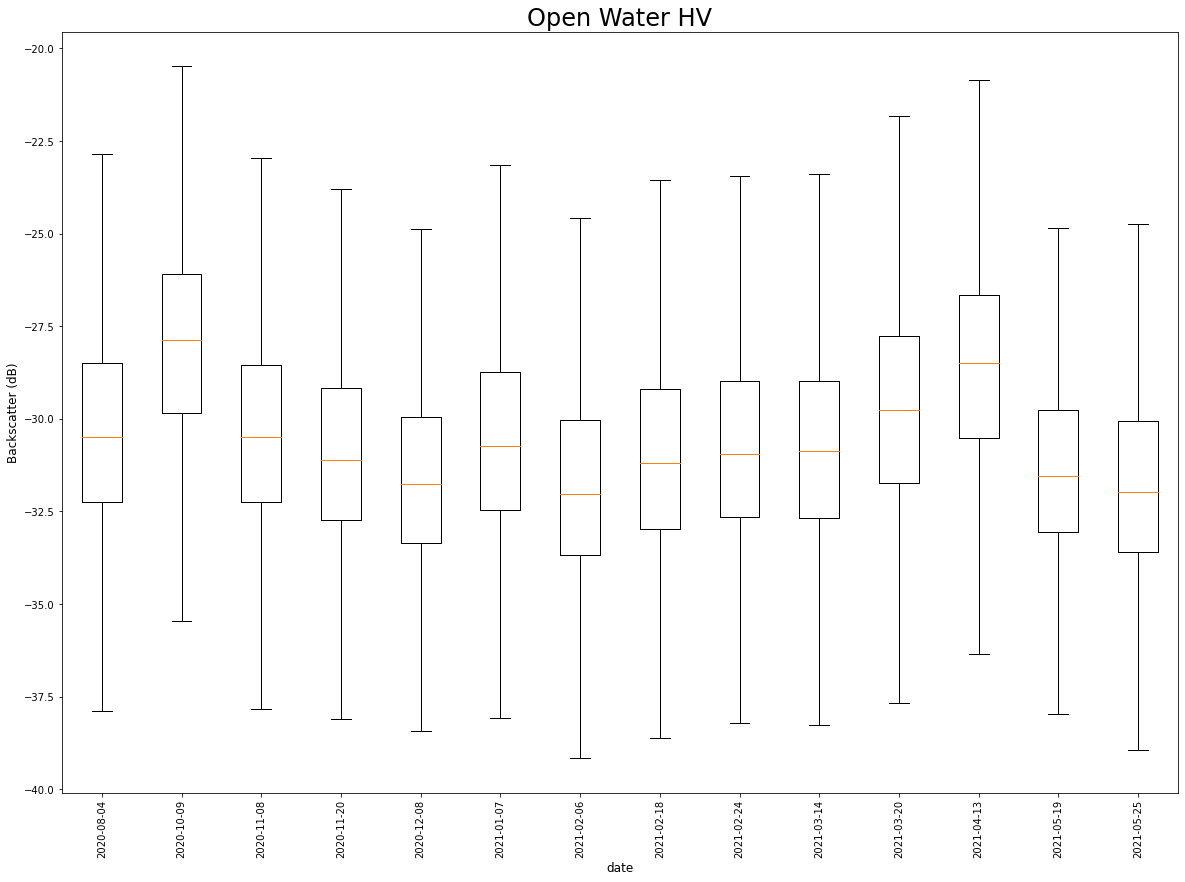

In [9]:
createBoxPlot('Open Water', ow2, dates_ow_h, 'HV', 83)

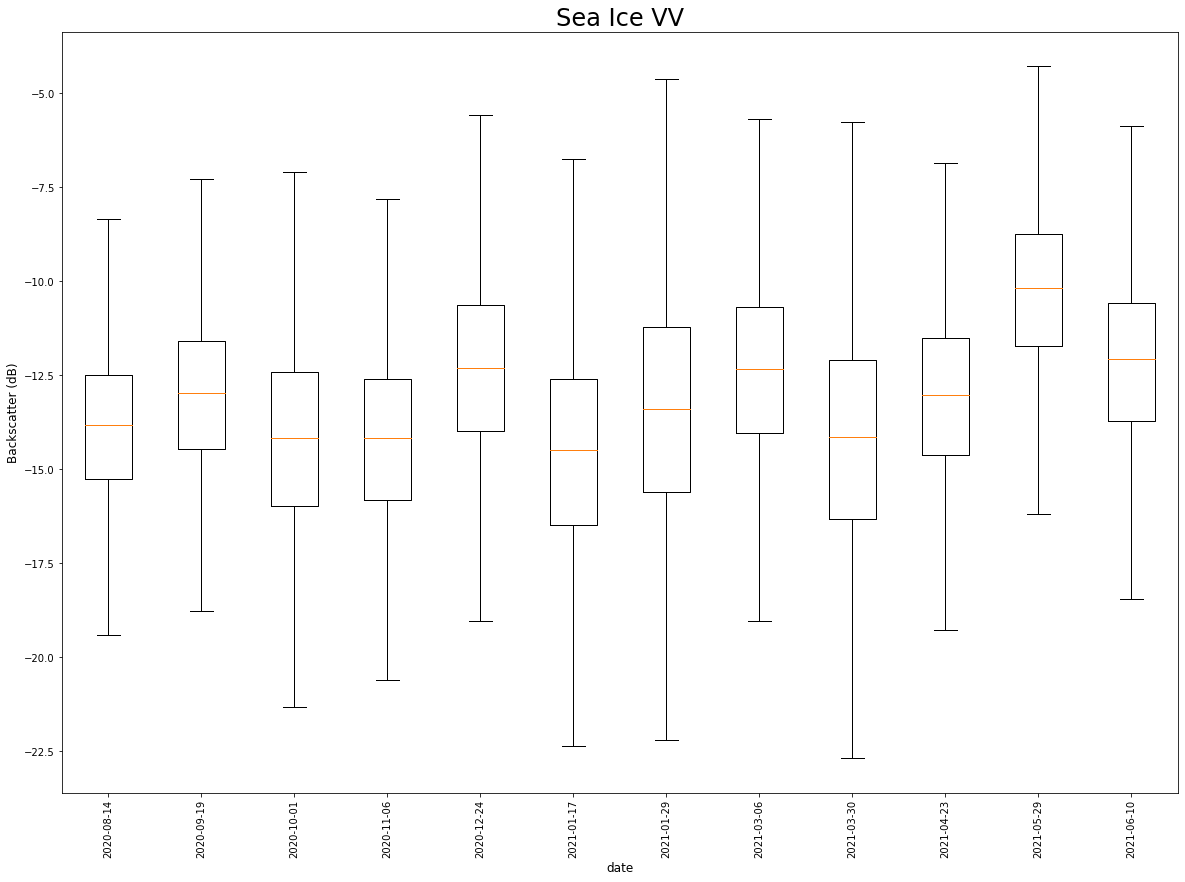

In [10]:
dates_si_v = [
    '2020-08-14',
    '2020-09-19',
    '2020-10-01',
    '2020-11-06',
    '2020-12-24',
    '2021-01-17',
    '2021-01-29',
    '2021-03-06',
    '2021-03-30',
    '2021-04-23',
    '2021-05-29',
    '2021-06-10'
]

createBoxPlot('Sea Ice', si1, dates_si_v, 'VV', 149)

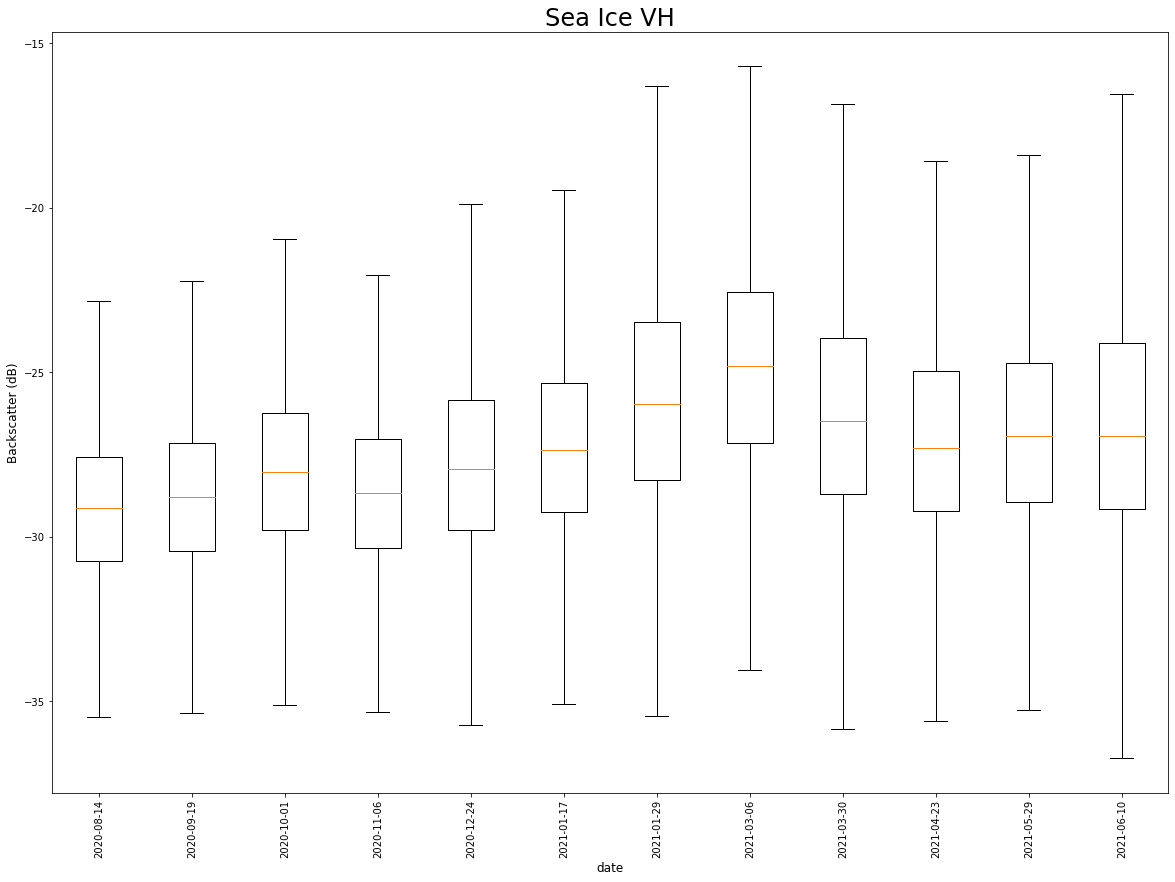

In [11]:
createBoxPlot('Sea Ice', si1, dates_si_v, 'VH', 149)

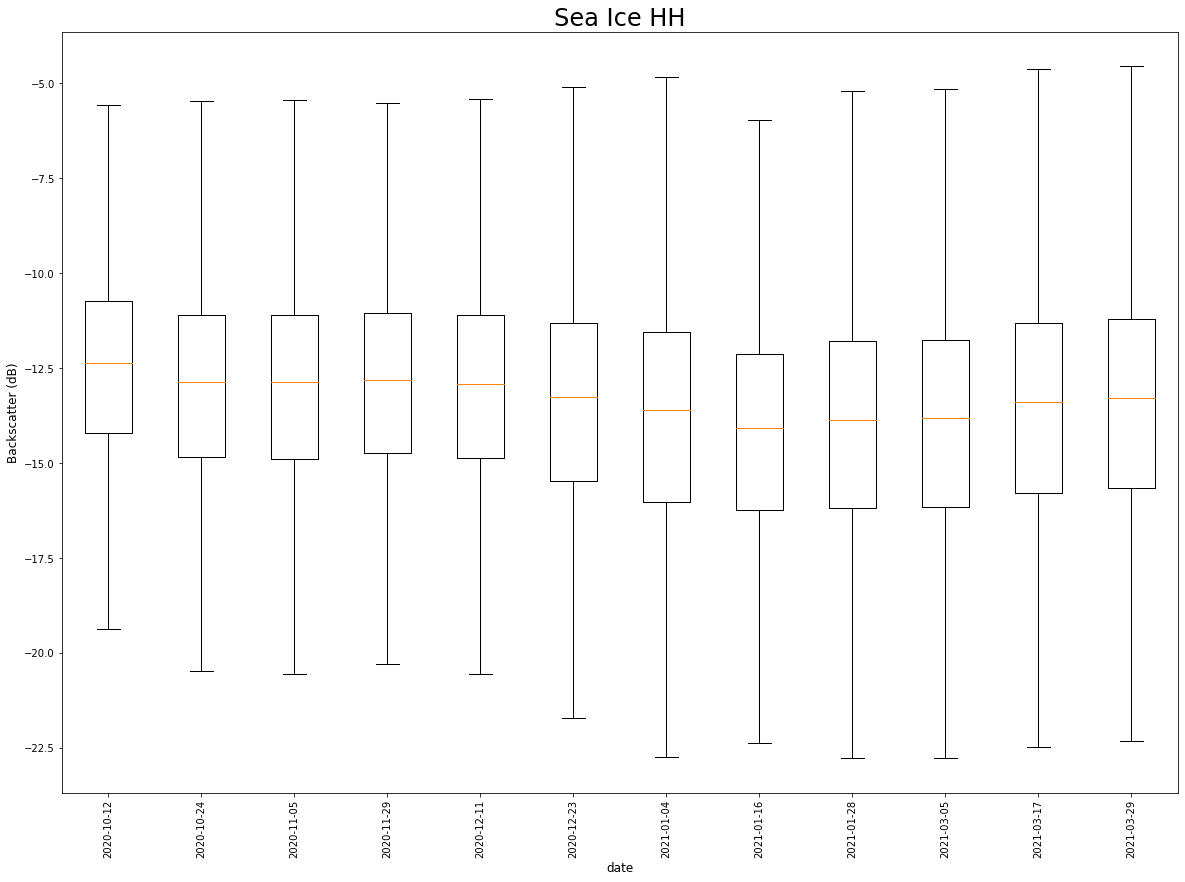

In [12]:
dates_si_h = [
    '2020-10-12',
    '2020-10-24',
    '2020-11-05',
    '2020-11-29',
    '2020-12-11',
    '2020-12-23',
    '2021-01-04',
    '2021-01-16',
    '2021-01-28',
    '2021-03-05',
    '2021-03-17',
    '2021-03-29'
]

createBoxPlot('Sea Ice', si2, dates_si_h, 'HH', 42)

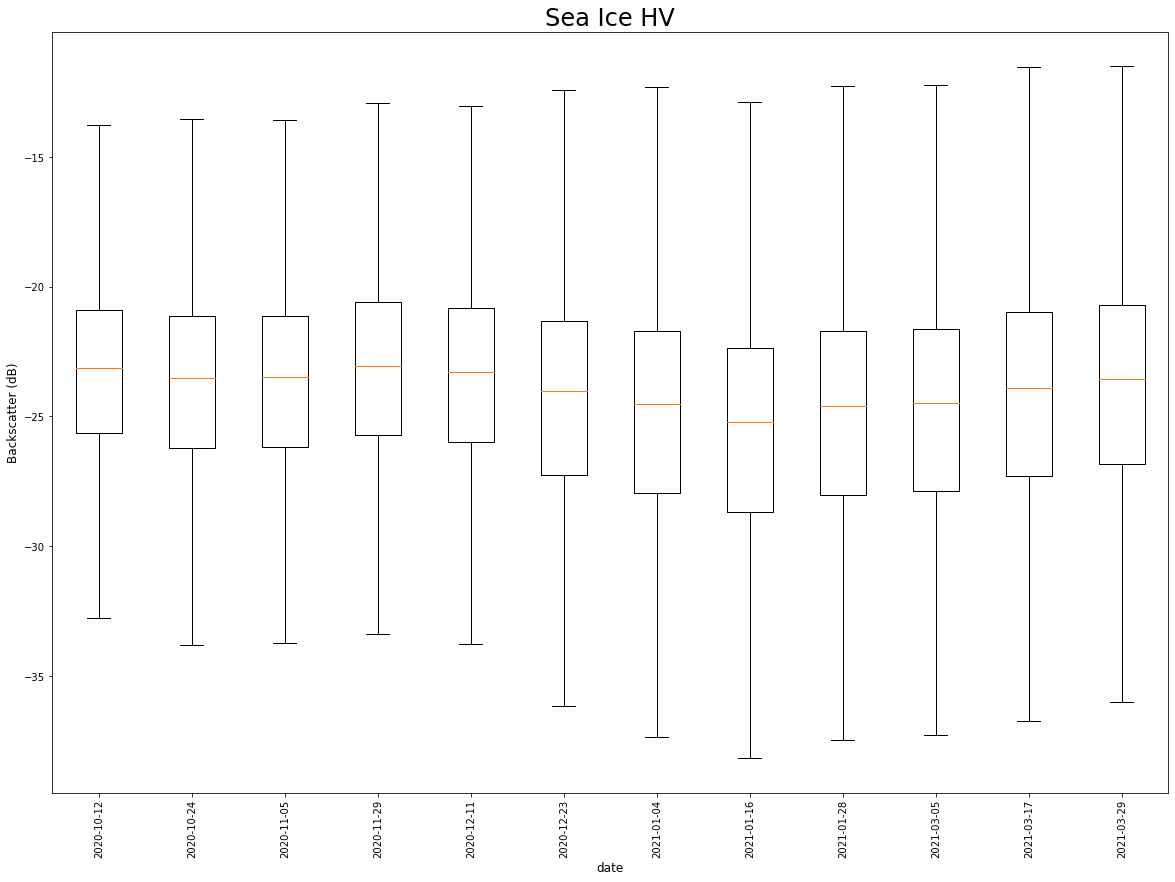

In [13]:
createBoxPlot('Sea Ice', si2, dates_si_h, 'HV', 42)